<a href="https://colab.research.google.com/github/tessamitchell/SchoolBusStopSignDetection/blob/main/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports & Data Set Up

In [ ]:
# Load libraries
from sklearn.ensemble import AdaBoostClassifier
from sklearn import datasets
# Import train_test_split function
from sklearn.model_selection import train_test_split
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
from skimage.feature import local_binary_pattern
from skimage.feature import haar_like_feature
from skimage.feature import hog

import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import xml.etree.ElementTree as ET

In [ ]:
# X=data
# y=data.labels

!pip install roboflow
from roboflow import Roboflow
from google.colab import userdata

rf = Roboflow(api_key=userdata.get('roboflow'))
project = rf.workspace("myworkspace-hr4qa").project("stop-signs-custom-umjoj")
version = project.version(8)
dataset = version.download("voc")



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 53.3 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Stop-Signs-Custom-8 in voc:: 100%|██████████| 405/405 [00:00<00:00, 3091.02it/s]


In [ ]:
import os
import random

def load_positive_windows(xml_path):
    pos_windows=[]
    neg_windows=[]

    for xml in os.listdir(xml_path):
      if xml.endswith(".xml"):
        img_name=xml.replace('.xml','.jpg')
        img_path = os.path.join(xml_path, img_name)
        if not os.path.exists(img_path):
            continue  # Skip if image file doesn't exist

        img=cv.imread(img_path)
        tree = ET.parse(os.path.join(xml_path, xml))
        root = tree.getroot()

        boxes = []
        for obj in root.findall("object"):
            bbox = obj.find("bndbox")
            xmin = int(bbox.find("xmin").text) -1
            ymin = int(bbox.find("ymin").text) -1
            xmax = int(bbox.find("xmax").text)
            ymax = int(bbox.find("ymax").text)
            pw=img[ymin:ymax,xmin:xmax]
            # pw=cv.resize(pw,(64,64))
            if obj.find("name").text == "stop sign":
              pos_windows.append(pw)
            else:
              neg_windows.append(pw)

    return pos_windows,neg_windows

In [ ]:
import glob

xml_path = "/content/Stop-Signs-Custom-8/train/"
# xml_path = "/content/Stop-Sign-1/train/"
# xml_paths = glob.glob("/content/*/*.xml", recursive=True) # for train valid and test xml
pos_images,neg_images=load_positive_windows(xml_path)

In [ ]:
# xml_path = "/content/Stop-Signs-Custom-6/train/"
# # xml_paths = glob.glob("/content/*/*.xml", recursive=True) # for train valid and test xml
# p2,n2=load_positive_windows(xml_path)
# pos_images.extend(p2)
# neg_images.extend(n2)

# Preprocessing

# Feature Extraction

[sci-kit lbp extraction](https://scikit-image.org/docs/0.25.x/auto_examples/features_detection/plot_local_binary_pattern.html)

In [ ]:
# https://scikit-image.org/docs/0.25.x/auto_examples/features_detection/plot_local_binary_pattern.html

radius=3
n_points=8*radius
METHOD = 'ror'
def extract_lbp(img):
  res=local_binary_pattern(img,n_points,radius,METHOD)
  return res.flatten()




[scikit haar face extraction](https://scikit-image.org/docs/0.25.x/auto_examples/applications/plot_haar_extraction_selection_classification.html)

[haar general additional link](https://scikit-image.org/docs/0.25.x/auto_examples/features_detection/plot_haar.html)

In [ ]:
feature_types = ['type-2-x', 'type-2-y', 'type-3-x', 'type-3-y', 'type-4']
def extract_haar(img):
  haar=haar_like_feature(img,0,0,img.shape[0],img.shape[1])
  return haar

In [ ]:
def extract_hog(img):
  feature=hog(img,orientations=9, pixels_per_cell=(16, 16),cells_per_block=(1, 1),visualize=False)
  return feature

In [ ]:
def extract_features(img):
  return np.concatenate([extract_lbp(img),extract_hog(img)])

231
1218


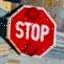

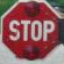

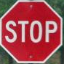

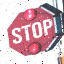

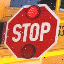

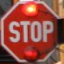

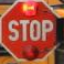

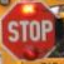

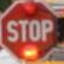

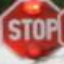

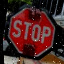

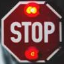

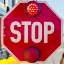

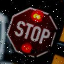

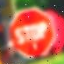

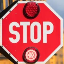

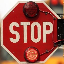

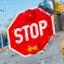

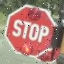

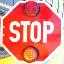

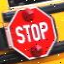

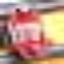

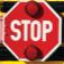

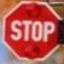

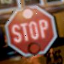

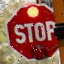

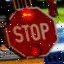

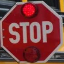

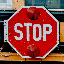

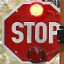

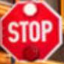

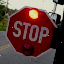

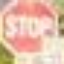

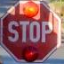

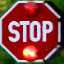

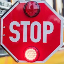

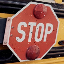

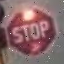

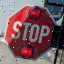

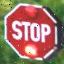

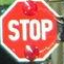

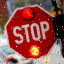

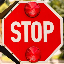

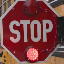

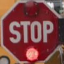

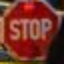

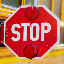

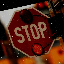

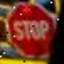

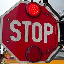

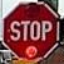

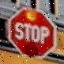

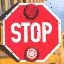

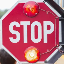

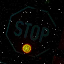

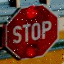

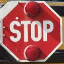

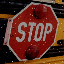

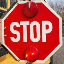

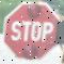

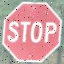

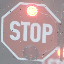

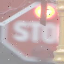

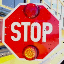

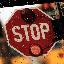

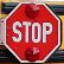

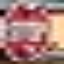

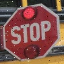

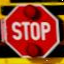

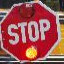

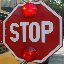

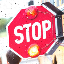

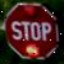

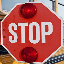

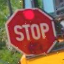

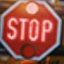

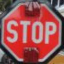

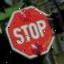

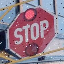

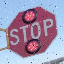

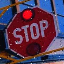

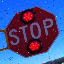

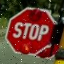

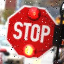

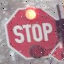

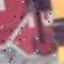

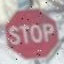

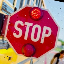

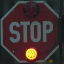

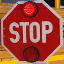

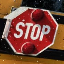

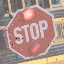

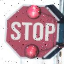

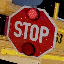

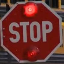

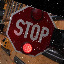

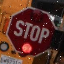

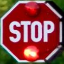

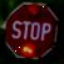

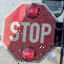

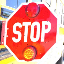

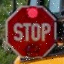

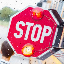

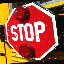

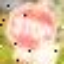

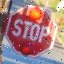

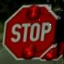

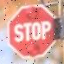

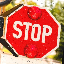

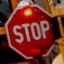

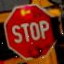

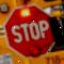

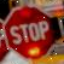

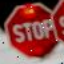

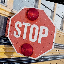

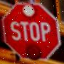

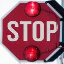

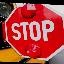

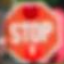

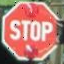

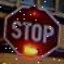

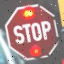

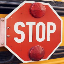

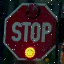

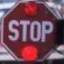

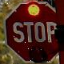

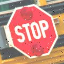

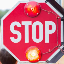

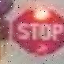

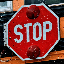

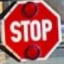

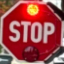

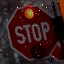

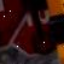

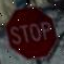

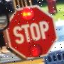

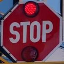

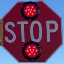

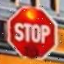

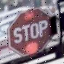

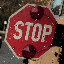

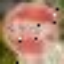

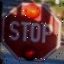

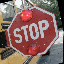

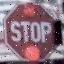

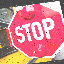

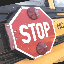

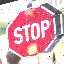

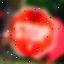

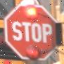

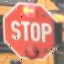

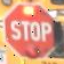

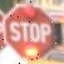

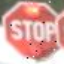

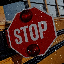

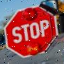

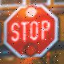

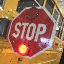

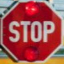

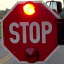

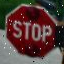

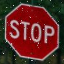

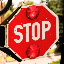

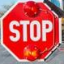

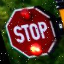

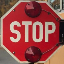

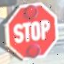

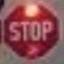

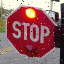

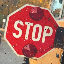

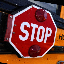

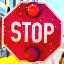

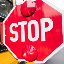

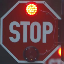

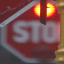

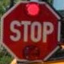

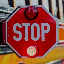

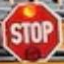

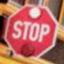

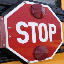

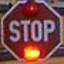

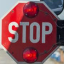

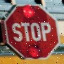

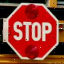

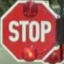

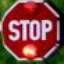

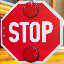

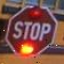

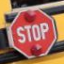

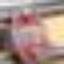

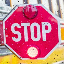

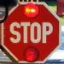

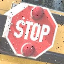

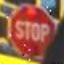

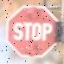

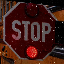

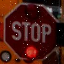

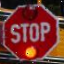

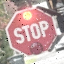

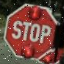

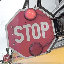

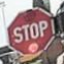

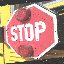

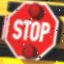

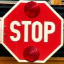

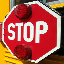

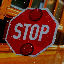

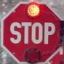

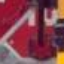

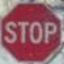

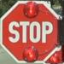

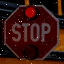

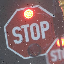

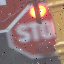

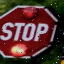

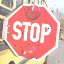

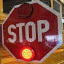

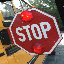

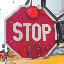

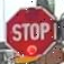

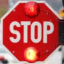

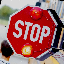

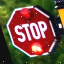

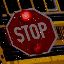

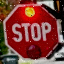

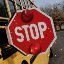

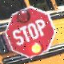

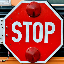

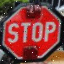

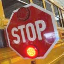

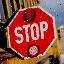

In [ ]:
print(len(pos_images))
print(len(neg_images))
# from google.colab.patches import cv2_imshow
# pos_images = [cv.normalize(img,None,0,255,cv.NORM_MINMAX) for img in pos_images]
for img in pos_images:
  cv2_imshow(img)
# # cv2_imshow(pos_images[53])

In [ ]:
# for img in neg_images:
#   cv2_imshow(img)

In [ ]:
# X_features=[]
# y_labels=[]

# # for window in pos_images:
# #   X_features.append(extract_features(window))
# #   y_labels.append(1)
# #   print(len(X_features))

# # for window in neg_images:
# #   X_features.append(extract_features(window))
# #   y_labels.append(0)
# #   print(len(X_features))
# pos_images = [img[:,:,2] for img in pos_images]
# neg_images = [img[:,:,2] for img in neg_images]

# X_features = [extract_features(w) for w in pos_images] + \
#              [extract_features(w) for w in neg_images]

# y_labels   = [1] * len(pos_images) + [0] * len(neg_images)

# import joblib



# joblib.dump(X_features, "adaboost_features5.pkl")
# joblib.dump(y_labels,"adaboost_labels5.pkl")

NameError: name 'pos_images' is not defined

# Training (Adaboost Cascade)

Adding these links here for any tabs I opened in my research that I might want to come back to

[sklearn adaboost tutorial](https://www.datacamp.com/tutorial/adaboost-classifier-python)

[another adaboost tutorial](https://www.kdnuggets.com/2022/10/implementing-adaboost-scikitlearn.html)

[sklearn adaboost documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

[adaboost from scratch](https://medium.com/@enozeren/building-the-adaboost-model-from-scratch-with-python-db3a8a763484)

[from scratch G4G](https://www.geeksforgeeks.org/machine-learning/implementing-the-adaboost-algorithm-from-scratch/)

[sklearn pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)

In [ ]:
import joblib
X_features=joblib.load("adaboost_features.pkl")
y_labels=joblib.load("adaboost_labels.pkl")

In [ ]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels, test_size=0.3,random_state=42) # 70% training and 30% test

# Create adaboost classifer object
abc = AdaBoostClassifier(n_estimators=50,
                         learning_rate=1)
# Train Adaboost Classifer
model = abc.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)

# Model Accuracy, how often is the classifier correct?
from sklearn.metrics import accuracy_score
print("Accuracy:",accuracy_score(y_test, y_pred))

# Accuracy: 0.8928571428571429
# Accuracy: 0.9642857142857143
# Accuracy: 0.9466666666666667
import joblib
joblib.dump(model, "adaboost_model5.pkl")
# 5 Accuracy: 0.9655172413793104

In [ ]:
import joblib
model=joblib.load("adaboost_model5.pkl")

# Extract Regions of Interest

In [ ]:
from imutils.object_detection import non_max_suppression
def extract_windows(img):
  windows=[]
  min_size=20
  for y in range(min_size,img.shape[0],8):
    for x in range(min_size, img.shape[1],8):
      windows.extend(pyramid(img,x,y))
  windows= non_max_suppression(windows, overlapThresh=0.3)

  # for y in range(0, img.shape[0] - window_size[1] + 1, step_size):
  #       for x in range(0, img.shape[1] - window_size[0] + 1, step_size):
  #           yield (x, y, img[y:y + window_size[1], x:x + window_size[0]])
  return windows

def pyramid(image, x,y, min_size=20):
    # yield image
    pos=[]
    h,w=image.shape
    size=min_size
    left=x-(size//2)
    top=y-(size//2)
    right =left+size
    bottom = top+size
    while( (left>=0) and (top>=0) and (right<w) and (bottom < h)  ):
      square=image[top:bottom,left:right]
      square= cv.resize(square,(64,64))
      feat=extract_features(square).reshape(1, -1)
      if(model.predict(feat)==1):
        pos.append((left,top,right,bottom))
      size+=20
      left=x-(size//2)
      top=y-(size//2)
      right = x+(size//2)
      bottom = y+(size//2)
    return pos


In [ ]:
def sliding_window(image, window_size, step_size):
    # Generate sliding windows with a given step size
    for y in range(0, image.shape[0] - window_size[1], step_size):
        for x in range(0, image.shape[1] - window_size[0], step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

def detect_objects(image, window_size=(64, 64), step_size=10, scale_factor=1.2, min_size=(30, 30)):
    detections = []
    original_image = image.copy()

    # Perform multi-scale sliding window
    scale = 1.0
    while min(image.shape[0], image.shape[1]) > min_size[0]:
        # Resize image to the current scale
        resized_image = cv.resize(original_image, (int(original_image.shape[1] * scale), int(original_image.shape[0] * scale)))

        # Sliding window at this scale
        for (x, y, window) in sliding_window(resized_image, window_size, step_size):
            # Extract features from the window
            resize=cv.resize(window,(64,64))
            window_features = extract_features(resize)

            # Predict using the classifier
            prediction = model.predict([window_features])

            if prediction == 1:  # Assuming 1 means positive detection
                detections.append((x, y, int(window_size[0] * scale), int(window_size[1] * scale)))

        # Increase scale for next iteration
        scale *= scale_factor
    windows= non_max_suppression(detections, overlapThresh=0.3)
    # Optional: Apply non-maxima suppression here to remove overlapping detections

    return windows


In [ ]:
import cv2 as cv
import numpy as np
testimg=cv.imread("/content/istockphoto-2157367693-612x612.jpg")
cropped=testimg[230:320,260:350]
# cropped=testimg[30:120,190:250]
# cropped=testimg[0:300,0:300]
from google.colab.patches import cv2_imshow
cv2_imshow(cropped)
red=cropped[:,:,2]
cv2_imshow(red)
# cropped=cv.resize(cropped,(64,64))




# img=testimg.copy()
# img=img[:,:,2]
# windows=detect_objects(img)
# for (x, y, w, h) in windows:
#         cv.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
# cv2_imshow(img)

# features=extract_features(red).reshape(1, -1)
# cv2_imshow(red)
# print(model.predict(features))



TypeError: 'NoneType' object is not subscriptable

In [ ]:
testimages=[]
positive_windows=[]
for img in testimages:
  windows=extract_windows(img)
  for (x,y,w,h) in windows:
    patch=img[x:x+h,y:y+w]

    positive_windows.append((img,patch,x,y,w,h))

In [ ]:
def test(imgs):
  pos_images=[]
  lights=[]
  neg_images=[]
  for img in imgs:
    # cv2_imshow(img)
    img=cv.resize(img,(64,64))
    cv2_imshow(img)
    red=img[:,:,2]
    cv2_imshow(red)
    feat=extract_features(red).reshape(1,-1)

    if model.predict(feat)==1:
        print("found")
        hw,count=houghAndValidation(red,img)

        if count>0:
          print("STOP")
          lights.append(hw)
          pos_images.append(hw)
        else:
          pos_images.append(img)
    else:
        neg_images.append(img)
  return pos_images,lights,neg_images

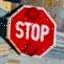

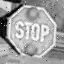

found


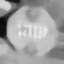

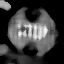

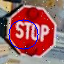

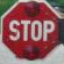

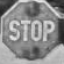

found


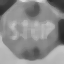

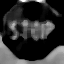

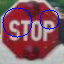

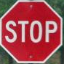

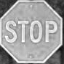

found


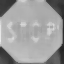

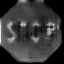

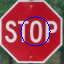

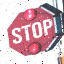

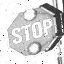

found


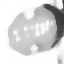

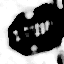

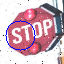

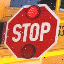

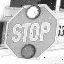

found


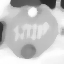

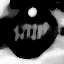

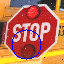

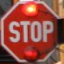

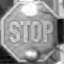

found


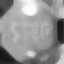

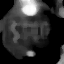

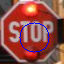

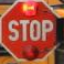

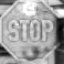

found


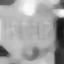

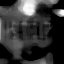

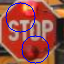

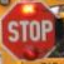

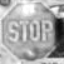

found


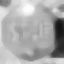

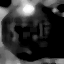

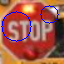

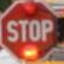

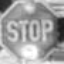

found


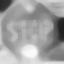

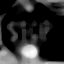

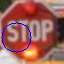

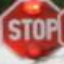

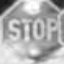

found


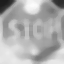

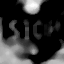

overflow encountered in scalar subtract


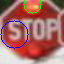

STOP


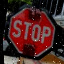

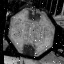

found


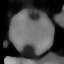

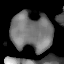

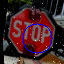

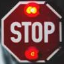

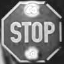

found


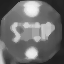

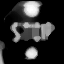

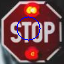

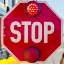

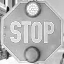

found


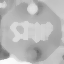

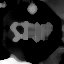

overflow encountered in scalar subtract


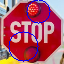

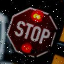

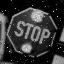

found


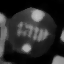

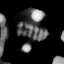

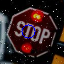

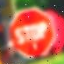

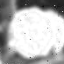

found


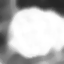

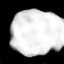

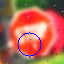

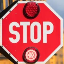

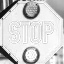

found


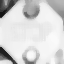

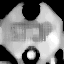

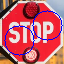

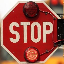

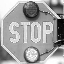

found


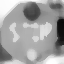

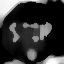

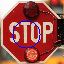

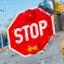

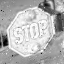

found


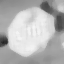

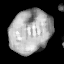

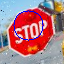

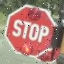

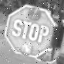

found


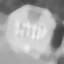

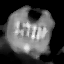

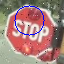

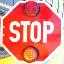

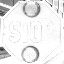

found


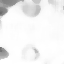

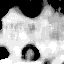

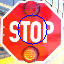

20
0
1


In [ ]:
from google.colab.patches import cv2_imshow
# test_images=np.concatenate([pos_images[:20],neg_images[:5]])
test_images=pos_images[:20]
# test_images=[cropped]
pos,lights,neg=test(test_images)
print(len(pos))
print(len(neg))
print(len(lights))

# Light Detection (Hough Circle Transform)

### Hough Circle Transform

In [ ]:
def preprocess(img):
  blurred=cv.medianBlur(img,7)
  # print(f"min:{blurred.min()} max:{blurred.max()}")
  cv2_imshow(blurred)
  avg=int(blurred.mean())
  med = (blurred.astype(np.float32)- avg)
  med[med < 0] = 0
  med=np.clip(med,0,255).astype(np.uint8)
  # print("test")
  med=cv.normalize(med,None,0,255,cv.NORM_MINMAX)
  cv2_imshow(med)

  return med

# documentation https://docs.opencv.org/4.x/dd/d1a/group__imgproc__feature.html#ga47849c3be0d0406ad3ca45db65a25d2d
def houghAndValidation(img,orig):
  img=img.copy()
  orig=orig.copy()
  img=preprocess(img)
  h,w=img.shape
  minR=int(img.shape[1]/10)
  maxR=int(img.shape[1]/4)
  # print(maxR)
  circles = cv.HoughCircles(img,cv.HOUGH_GRADIENT,1.5,30,
                              param1=50,param2=20,minRadius=minR,maxRadius=maxR)
  if circles is None:
    return [],0
  # print(circles)
  circles = np.uint16(np.around(circles))
  # print(len(circles))
  # validation
  count=0
  for c in circles[0]:
    # print(f"{type(c[0])} {type(c[1])} {type(c[2])}")
    right_edge=c[0]+c[2]
    left_edge=c[0]-c[2]
    top_edge=c[1]-c[2]
    bottom_edge=c[1]+c[2]
    if((right_edge<(w * (3/4)) and (left_edge>(w//4)))  and ((bottom_edge<(h/2)) or (top_edge>(h/2)))):
      cv.circle(orig, (c[0], c[1]), c[2], (0, 255, 0), 1)
      count+=1
    else:
        cv.circle(orig, (c[0], c[1]), c[2], (255, 0, 0), 1)



    # compare radius with bounding box of stop sign

    # get average intensity value and compare to red section of stop sign

    # compare location
    # if(c[1]+c[2] < )
  cv2_imshow(orig)
  return orig,count

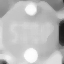

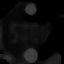

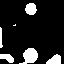

16
[[[30.75 54.75  6.6 ]]]


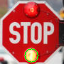

In [ ]:
# pos_window format img,patch,x,y,w,h
# for img,patch,x,y,w,h in positive_windows:
#   hw=houghAndValidation(patch,img)
#   drawbounds(img,(hw),(x,y,w,h))
houghAndValidation(red,cropped)

# Outputs

In [ ]:
# https://docs.opencv.org/4.x/dc/da5/tutorial_py_drawing_functions.html
def drawBounds(img,circle,box):
  x=box[0]
  y=box[1]
  for c in circle:
    cv.circle(img,(y+circle[0],x+circle[1]),circle[2],(255,0,0),2)

  cv.rectangle(img,(box[0],box[1]),(box[2],box[3]),(0,255,0),2)

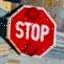

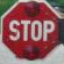

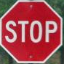

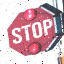

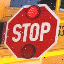

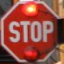

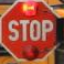

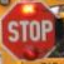

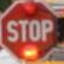

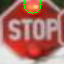

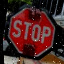

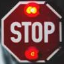

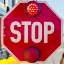

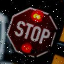

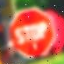

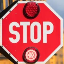

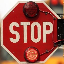

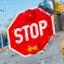

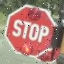

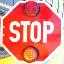

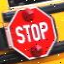

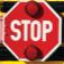

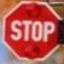

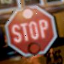

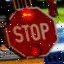

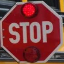

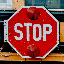

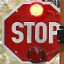

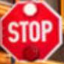

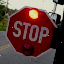

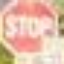

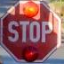

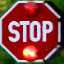

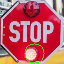

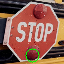

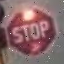

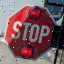

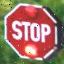

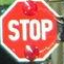

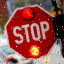

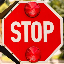

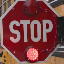

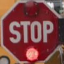

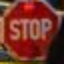

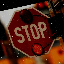

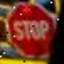

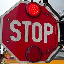

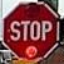

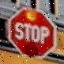

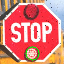

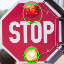

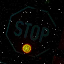

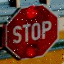

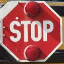

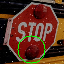

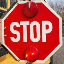

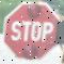

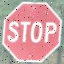

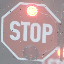

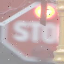

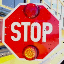

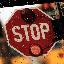

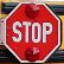

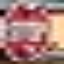

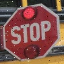

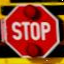

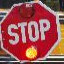

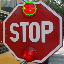

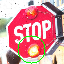

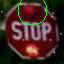

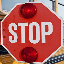

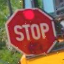

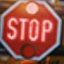

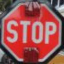

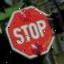

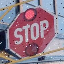

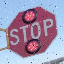

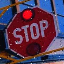

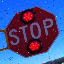

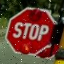

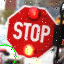

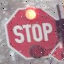

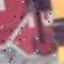

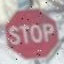

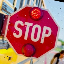

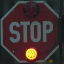

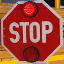

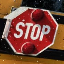

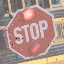

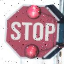

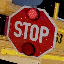

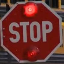

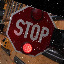

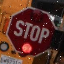

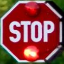

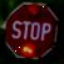

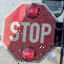

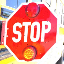

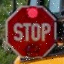

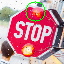

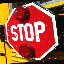

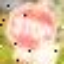

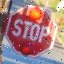

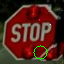

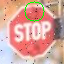

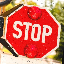

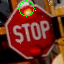

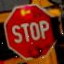

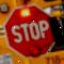

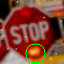

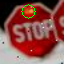

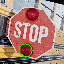

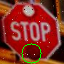

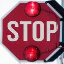

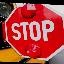

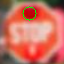

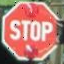

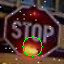

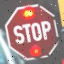

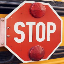

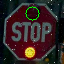

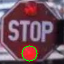

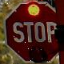

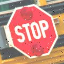

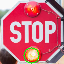

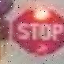

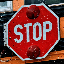

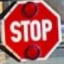

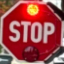

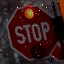

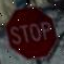

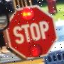

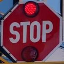

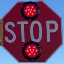

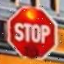

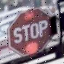

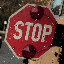

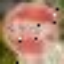

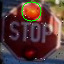

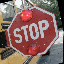

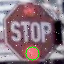

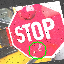

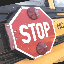

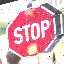

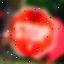

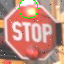

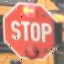

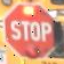

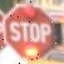

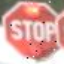

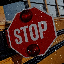

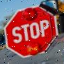

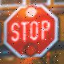

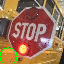

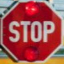

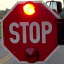

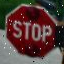

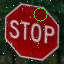

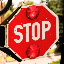

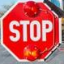

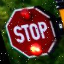

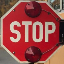

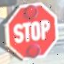

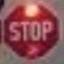

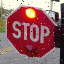

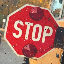

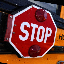

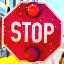

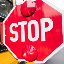

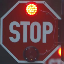

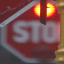

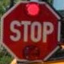

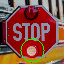

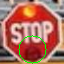

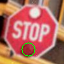

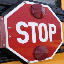

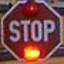

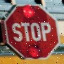

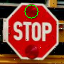

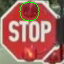

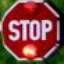

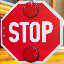

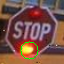

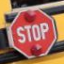

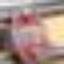

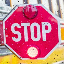

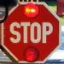

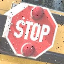

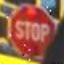

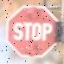

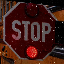

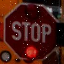

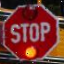

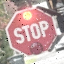

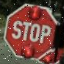

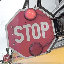

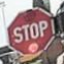

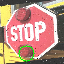

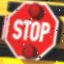

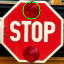

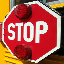

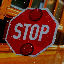

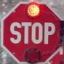

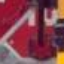

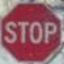

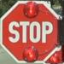

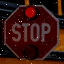

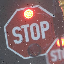

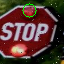

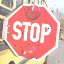

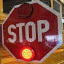

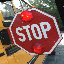

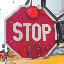

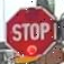

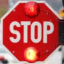

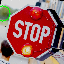

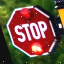

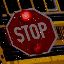

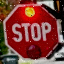

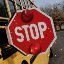

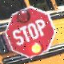

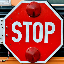

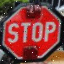

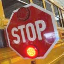

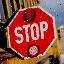

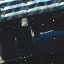

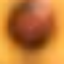

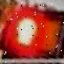

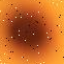

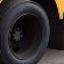

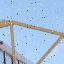

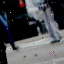

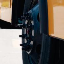

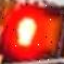

In [ ]:
for im in pos:
  if isinstance(im, np.ndarray):
        cv2_imshow(im)


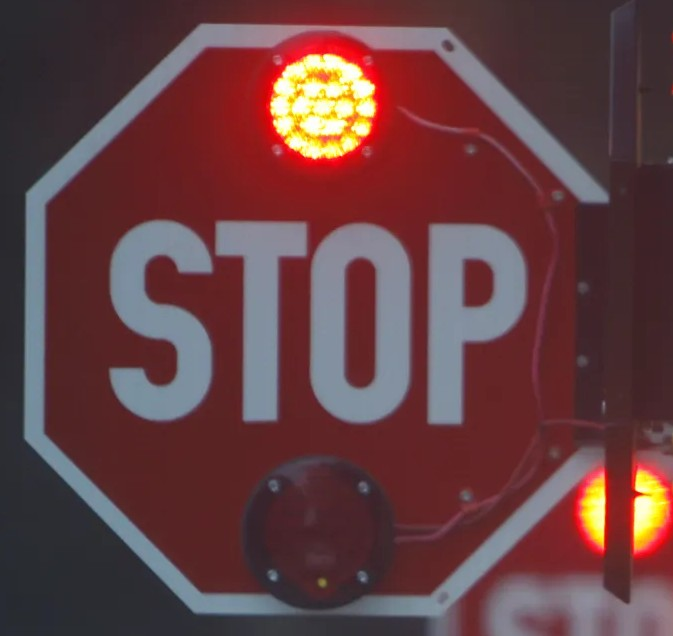

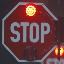

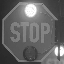

found


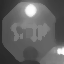

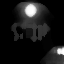

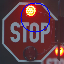

In [ ]:
testimg=cv.imread("test2.jpg")
cv2_imshow(testimg)
p,l,n = test([testimg])



Light

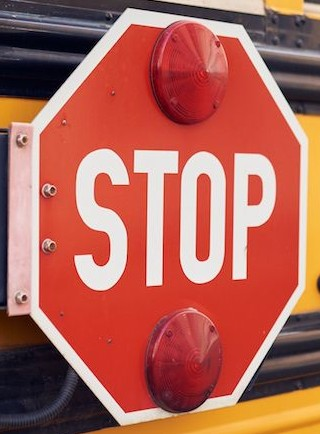

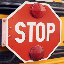

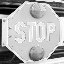

found


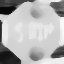

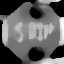

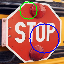

STOP


In [ ]:
testimg=cv.imread("test11.jpg")
cv2_imshow(testimg)
p,l,n = test([testimg])


Not a stop sign

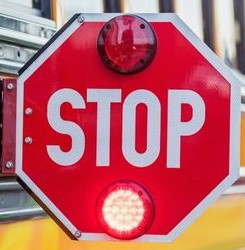

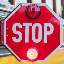

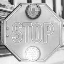

found


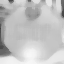

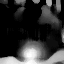

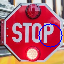

In [ ]:
testimg=cv.imread("test17.jpg")
cv2_imshow(testimg)
p,l,n = test([testimg])